In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms.v2 as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import sys
print(sys.executable)

c:\Python314\python.exe


In [5]:
import os

# Your correct path (with OneDrive)
segmented = r'C:\Users\avaya\OneDrive\Documents\plant_project\segmented'

# Verify the path exists
if not os.path.exists(segmented):
    print(f"ERROR: Path does not exist: {segmented}")
    print("Please check the path and try again")
else:
    print(f"Data path found: {segmented}")
    # Show what folders are inside
    subfolders = os.listdir(segmented)
    print(f"Found {len(subfolders)} classes: {subfolders}")
    
    # Count images in each class
    for folder in subfolders:
        folder_path = os.path.join(segmented, folder)
        if os.path.isdir(folder_path):
            num_images = len([f for f in os.listdir(folder_path) 
                            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.PNG'))])
            print(f"  - {folder}: {num_images} images")


Data path found: C:\Users\avaya\OneDrive\Documents\plant_project\segmented
Found 2 classes: ['Apple___Black_rot', 'Apple___healthy']
  - Apple___Black_rot: 621 images
  - Apple___healthy: 1645 images


In [4]:
import torchvision.transforms.v2 as transforms

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Transforms created")

Transforms created


In [5]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
try:
    train_file = ImageFolder(root=segmented, transform=train_transforms)
    val_file = ImageFolder(root=segmented, transform=val_transforms)
except FileNotFoundError:
    print("File not found")

train_size = int(0.8 * len(train_file))
test_size = int(0.1 * len(train_file))
valid_size = len(train_file) - test_size - train_size

train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(
    train_file, [train_size, test_size, valid_size]
)

val_indices = valid_dataset.indices
val_dataset_proper = torch.utils.data.Subset(val_file, val_indices)

In [7]:
BATCH_SIZE = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(dataset=val_dataset_proper, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1812
Validation samples: 228
Test samples: 226


In [8]:
weights = models.ResNet18_Weights.DEFAULT
model = models.resnet18(weights=weights)

num_classes = 2
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Using device: {device}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\avaya/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Using device: cpu


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [11]:
num_epochs = 5
train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, valid_loader, criterion, device)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    
    scheduler.step(val_acc)

Epoch 1/15
Train Loss: 0.0751, Train Acc: 97.46%
Val Loss: 0.0012, Val Acc: 100.00%
--------------------------------------------------
New best model saved with validation accuracy: 100.00%
Epoch 2/15
Train Loss: 0.0270, Train Acc: 99.23%
Val Loss: 0.0005, Val Acc: 100.00%
--------------------------------------------------
Epoch 3/15
Train Loss: 0.0322, Train Acc: 98.90%
Val Loss: 0.0372, Val Acc: 98.68%
--------------------------------------------------
Epoch 4/15
Train Loss: 0.0329, Train Acc: 99.01%
Val Loss: 0.0106, Val Acc: 99.56%
--------------------------------------------------
Epoch 5/15
Train Loss: 0.0198, Train Acc: 99.28%
Val Loss: 0.0026, Val Acc: 100.00%
--------------------------------------------------


KeyboardInterrupt: 

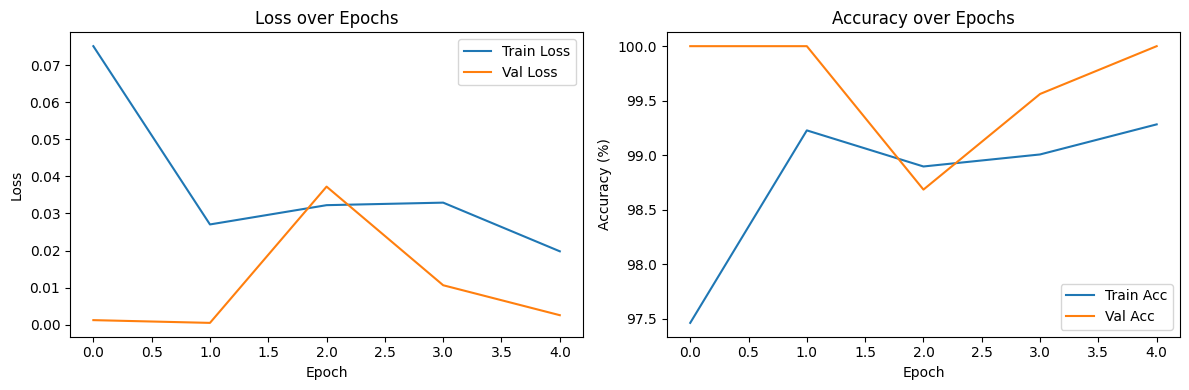

In [12]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

In [13]:
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:.2f}%')

Test Accuracy: 99.56%
